<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение 2
### Семинар 11. Многорукие бандиты

<br />
<br />
28 апреля 2022

The Multi-Armed Bandit problem (MAB) is a special case of Reinforcement Learning: an agent collects rewards in an environment by taking some actions after observing some state of the environment. The main difference between general RL and MAB is that in MAB, we assume that the action taken by the agent does not influence the next state of the environment. Therefore, agents do not model state transitions, credit rewards to past actions, or "plan ahead" to get to reward-rich states.

As in other RL domains, the goal of a MAB agent is to find a policy that collects as much reward as possible. It would be a mistake, however, to always try to exploit the action that promises the highest reward, because then there is a chance that we miss out on better actions if we do not explore enough. This is the main problem to be solved in (MAB), often called the exploration-exploitation dilemma.

Bandit environments, policies, and agents for MAB can be found in subdirectories of tf_agents/bandits.


In [1]:
import time
import numpy as np
import functools
import matplotlib.pyplot as plt
from tqdm import tqdm

Сделаем простейшую реализацию многорукого бандита и нескольки базовых стратегий (epsilon-greedy, UCB1)

In [2]:
class Bandit(object):

    def generate_reward(self, i: int):
        raise NotImplementedError

    def generate_optimal_reward(self):
        raise NotImplementedError

    def __str__(self):
        raise NotImplementedError


In [3]:
class BernoulliBandit(Bandit):

    def __init__(self, n: int, probas=None):
        assert probas is None or len(probas) == n
        self.n = n
        if probas is None:
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            self.probas = probas

        self.best_proba_i = np.argmax(self.probas)
        self.best_proba = self.probas[self.best_proba_i]

    def __str__(self):
        return "BernoulliBandit: [" + ", ".join(["{:.2f}".format(p) for p in self.probas]) + "]"

    def generate_reward(self, i: int):
        # The player selected the i-th machine.
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

    def generate_optimal_reward(self):
        return self.generate_reward(self.best_proba_i)

In [4]:
np.random.seed(100500)
bandit_1 = BernoulliBandit(5)
bandit_2 = BernoulliBandit(5, probas = [0.4, 0.5, 0.45, 0.53, 0.47])
print(bandit_1)
print(bandit_2)

BernoulliBandit: [0.14, 0.10, 0.97, 0.09, 0.77]
BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]


In [5]:
class Agent(object):
    def __init__(self, bandit):
        self.bandit = bandit

    def __str__(self):
        raise NotImplementedError

    def run_one_step(self):
        """Return the machine index to take action on AND obtained reward"""
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError


class Experiment(object):
    def __init__(self, bandit, agent):
        self.bandit = bandit
        self.agent = agent(bandit)
        self.agent.reset()
        self.actions = []
        self.regret = 0.  # Cumulative regret
        self.regrets = [0.]  # History of cumulative regret

    def __str__(self):
        return 'Experiment: "{}" vs "{}"'.format(str(self.agent), str(self.bandit))

    def reset(self):
        self.actions = []  # A list of machine ids
        self.regret = 0.  # Cumulative regret
        self.regret_smooth = 0.
        self.regrets = [0.]  # History of cumulative regret
        self.regrets_smooth = [0.]  # History of cumulative regret
        self.agent.reset()

    def update_regret(self, i, r):
        # i (int): index of the selected machine
        # r (float): obtained reward
        self.regret += self.bandit.generate_optimal_reward() - r
        self.regret_smooth += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)
        self.regrets_smooth.append(self.regret_smooth)

    def run(self, num_steps):
        assert self.bandit is not None
        assert self.agent is not None
        self.reset()
        for _ in range(num_steps):
            i, r = self.agent.run_one_step()
            self.actions.append(i)
            self.update_regret(i, r)

class EpsilonGreedyAgent(Agent):
    def __init__(self, bandit, eps):
        super(EpsilonGreedyAgent, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        assert bandit is not None

        self.eps = eps
        self.reset()

    def __str__(self):
        return "epsilon greedy: {}".format(self.eps)

    def reset(self):
        # в качестве инициализации дернем за каждую ручку
        self.rewards = [self.bandit.generate_reward(i)
                        for i in range(self.bandit.n)]
        self.counts = [1] * self.bandit.n
        # self.rewards = [0] * self.bandit.n
        # self.counts = [0] * self.bandit.n

    def run_one_step(self):
        if np.random.random() < self.eps:
            # случайный выбор
            i = np.random.randint(0, self.bandit.n)
        else:
            # выбираем лучшего по средней награде
            i = max(range(self.bandit.n),
                    key=lambda k: float(self.rewards[k]) / (self.counts[k]))

        r = self.bandit.generate_reward(i)
        self.rewards[i] += r
        self.counts[i] += 1
        # self.estimates[i] = float(self.rewards_sum[i]) / (self.counts[i] + 1)
        # self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])
        return i, r

In [6]:
eps_greedy_values = [1., 0.25, 0.1, 0.01, 0.]

eps_agents = [
    functools.partial(EpsilonGreedyAgent, eps=eps_val) for eps_val in eps_greedy_values
]

In [7]:
# почему random?
agent_random = eps_agents[0](bandit_1)
print(agent_random)

epsilon greedy: 1.0


Run experiment: Experiment: "epsilon greedy: 1.0" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 572.0
Run experiment: Experiment: "epsilon greedy: 0.25" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 104.0
Run experiment: Experiment: "epsilon greedy: 0.1" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 137.0
Run experiment: Experiment: "epsilon greedy: 0.01" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 185.0
Run experiment: Experiment: "epsilon greedy: 0.0" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 618.0


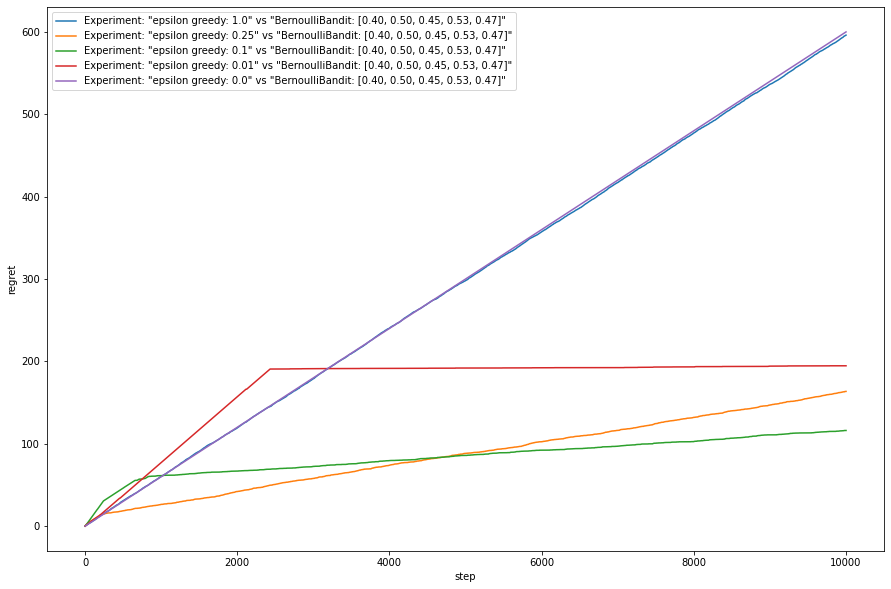

In [8]:
num_steps = 10000
np.random.seed(100500) # epsilon greedy: 0.0 и epsilon greedy: 0.01 проигрывают
# np.random.seed(200) # выигрывает epsilon greedy: 0.01
# np.random.seed(500) # выигрывает epsilon greedy: 0.0

plt.figure(figsize=(15, 10))
legend = []
for agent in eps_agents:
    experiment = Experiment(bandit_2, agent)
    print("Run experiment: {}".format(str(experiment)))
    experiment.run(num_steps)
    print("Regret: {}".format(experiment.regret))
    legend.append(str(experiment))
    # plt.plot(experiment.regrets)
    plt.plot(experiment.regrets_smooth)  # более гладкие графики
plt.ylabel("regret")
plt.xlabel("step")
plt.legend(legend)
plt.show()

Попробуем посчитать среднее значение regret для серии экспериментов

In [9]:
def calc_average_regret(bandit, agents, num_experiments=100, num_steps=10000):
    average_regret = np.zeros(len(agents), dtype=np.float)
    for iter in tqdm(range(num_experiments)):
        for agent_idx, agent in enumerate(agents):
            experiment = Experiment(bandit, agent)
            experiment.run(num_steps)
            average_regret[agent_idx] += experiment.regret * (1./num_experiments)
            # average_regret[agent_idx] += experiment.regret_smooth * (1./num_experiments)
    return average_regret

In [10]:
bandit_2_average_regrets = calc_average_regret(bandit_2, eps_agents)
print(bandit_2_average_regrets)

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

[611.87 184.97 139.2  236.25 436.11]


In [12]:
bandit_2_average_regrets = calc_average_regret(bandit_2, eps_agents)
print(bandit_2_average_regrets)

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

[602.06 191.79 173.49 266.8  414.73]


От запуска к запуску картина становится стабильной, оптимальное значение epsilon где-то в районе 0.1-0.2

In [13]:
eps_greedy_values

[1.0, 0.25, 0.1, 0.01, 0.0]

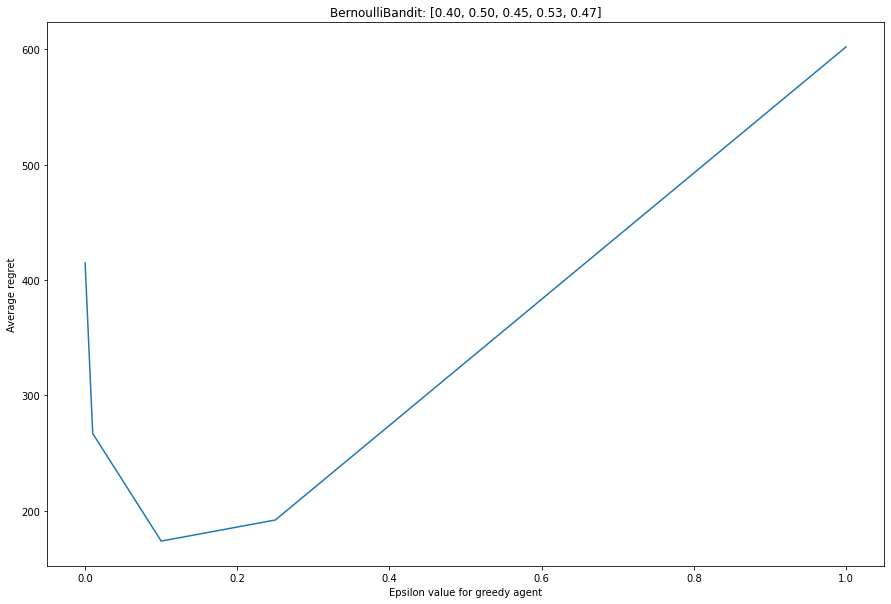

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(eps_greedy_values, bandit_2_average_regrets)
plt.title(str(bandit_2))
plt.xlabel("Epsilon value for greedy agent")
plt.ylabel("Average regret")
plt.show()

In [15]:
bandit_1_average_regrets = calc_average_regret(bandit_1, eps_agents, num_experiments=1000, num_steps=500)

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.89it/s]


In [16]:
print(bandit_1)

BernoulliBandit: [0.14, 0.10, 0.97, 0.09, 0.77]


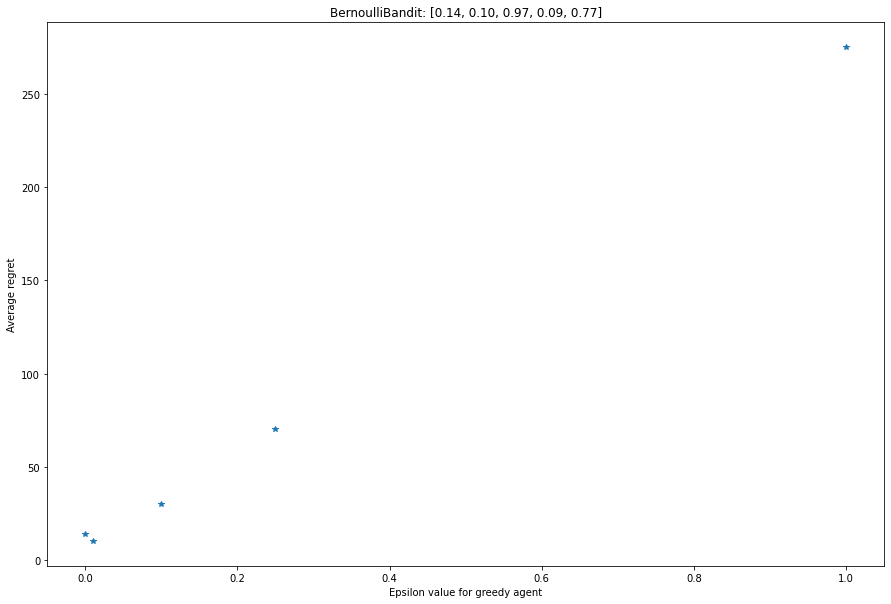

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(eps_greedy_values, bandit_1_average_regrets, "*")
plt.title(str(bandit_1))
plt.xlabel("Epsilon value for greedy agent")
plt.ylabel("Average regret")
plt.show()

Картина выглядит совершенно иначе. Почему?

Добавим UCB1

In [18]:
# https://habr.com/ru/company/surfingbird/blog/168611/

class UCB1Agent(Agent):
    def __init__(self, bandit):
        super(UCB1Agent, self).__init__(bandit)
        self.reset()

    def __str__(self):
        return "UCB1"

    def reset(self):
        # в качестве инициализации дернем за каждую ручку
        self.rewards = [self.bandit.generate_reward(i)
                        for i in range(self.bandit.n)]
        self.counts = [1] * self.bandit.n
        # self.rewards = [0] * self.bandit.n
        # self.counts = [0] * self.bandit.n

    def get_estimates(self):
        mean_rewards = np.array(self.rewards, dtype=np.float) / self.counts
        additional_terms = np.sqrt(
            2. * np.log(np.sum(self.counts)) / self.counts)
        return mean_rewards + additional_terms

    def run_one_step(self):
        estimates = self.get_estimates()
        i = np.argmax(estimates)
        r = self.bandit.generate_reward(i)
        self.rewards[i] += r
        self.counts[i] += 1
        return i, r

Run experiment: Experiment: "epsilon greedy: 1.0" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 2827.0
Run experiment: Experiment: "epsilon greedy: 0.25" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 508.0
Run experiment: Experiment: "epsilon greedy: 0.1" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 598.0
Run experiment: Experiment: "epsilon greedy: 0.01" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 377.0
Run experiment: Experiment: "epsilon greedy: 0.0" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"
Regret: 3922.0
Run experiment: Experiment: "UCB1" vs "BernoulliBandit: [0.40, 0.50, 0.45, 0.53, 0.47]"


/tmp/ipykernel_29323/2206694424.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_rewards = np.array(self.rewards, dtype=np.float) / self.counts


Regret: 482.0


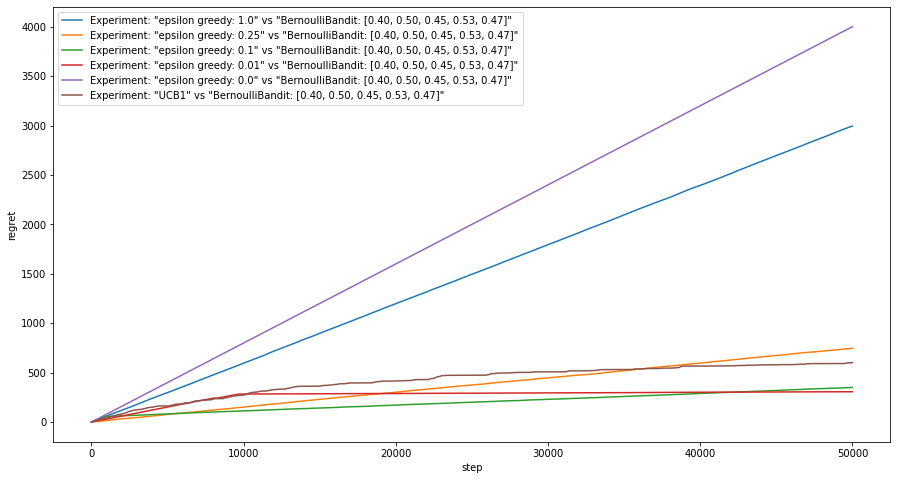

In [19]:
num_steps = 50000
np.random.seed(100500) # epsilon greedy: 0.0 и epsilon greedy: 0.01 проигрывают
# np.random.seed(200) # выигрывает epsilon greedy: 0.01
# np.random.seed(500) # выигрывает epsilon greedy: 0.0

plt.figure(figsize=(15, 8))
legend = []
for agent in eps_agents + [UCB1Agent]:
    experiment = Experiment(bandit_2, agent)
    print("Run experiment: {}".format(str(experiment)))
    experiment.run(num_steps)
    print("Regret: {}".format(experiment.regret))
    legend.append(str(experiment))
    # plt.plot(experiment.regrets)
    plt.plot(experiment.regrets_smooth)
plt.ylabel("regret")
plt.xlabel("step")
plt.legend(legend)
plt.show()

In [20]:
bandit_2_average_regrets = calc_average_regret(bandit_2, eps_agents + [UCB1Agent])

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
  0%|                                                                                                 | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_29323/2206694424.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

In [21]:
bandit_2_average_regrets

array([607.11, 187.34, 141.73, 181.7 , 415.79, 275.72])

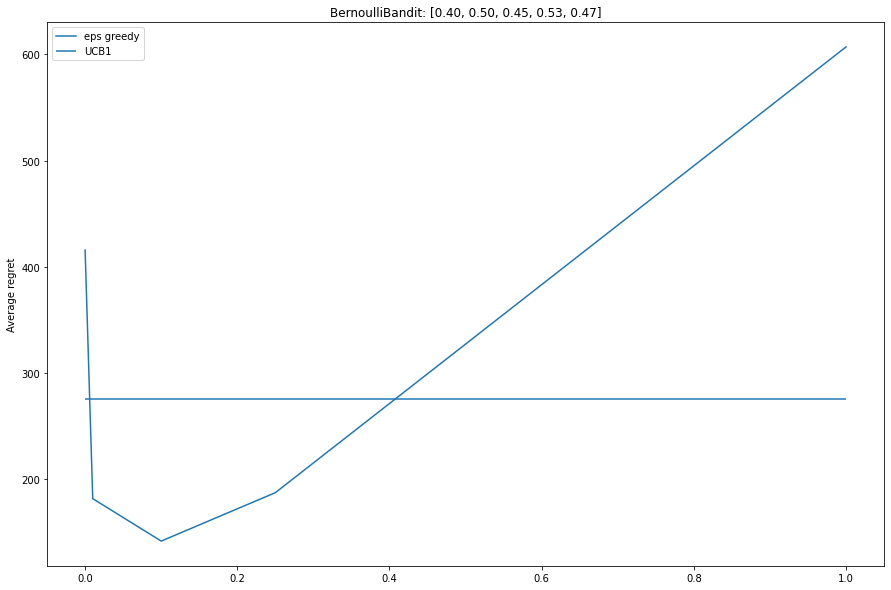

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(eps_greedy_values, bandit_2_average_regrets[:-1])
plt.hlines(bandit_2_average_regrets[-1], 0, 1)
plt.legend(['eps greedy', 'UCB1'])
plt.title(str(bandit_2))
plt.ylabel("Average regret")
plt.show()

In [23]:
bandit_1_average_regrets = calc_average_regret(bandit_1, eps_agents[1:] + [UCB1Agent]) # без random

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
  0%|                                                                                                 | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_29323/2206694424.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

In [24]:
bandit_1_average_regrets

array([1380.38,  555.4 ,   99.02,   76.19,  119.27])

In [25]:
print(bandit_1)

BernoulliBandit: [0.14, 0.10, 0.97, 0.09, 0.77]


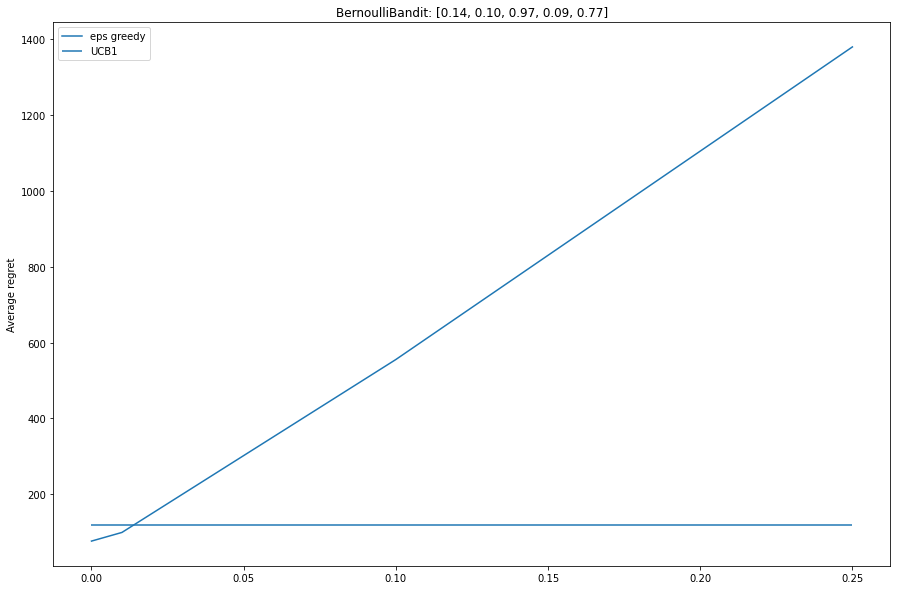

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(eps_greedy_values[1:], bandit_1_average_regrets[:-1])
plt.hlines(bandit_1_average_regrets[-1], 0., 0.25)
plt.legend(['eps greedy', 'UCB1'])
plt.title(str(bandit_1))
plt.ylabel("Average regret")
plt.ylim()
plt.show()

In [27]:
# оценка стратегий за меньшее количество шагов
bandit_2_average_regrets_short = calc_average_regret(bandit_2, eps_agents + [UCB1Agent], num_experiments=500, num_steps=1000)

/tmp/ipykernel_29323/1672512482.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  average_regret = np.zeros(len(agents), dtype=np.float)
  0%|                                                                                                 | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_29323/2206694424.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

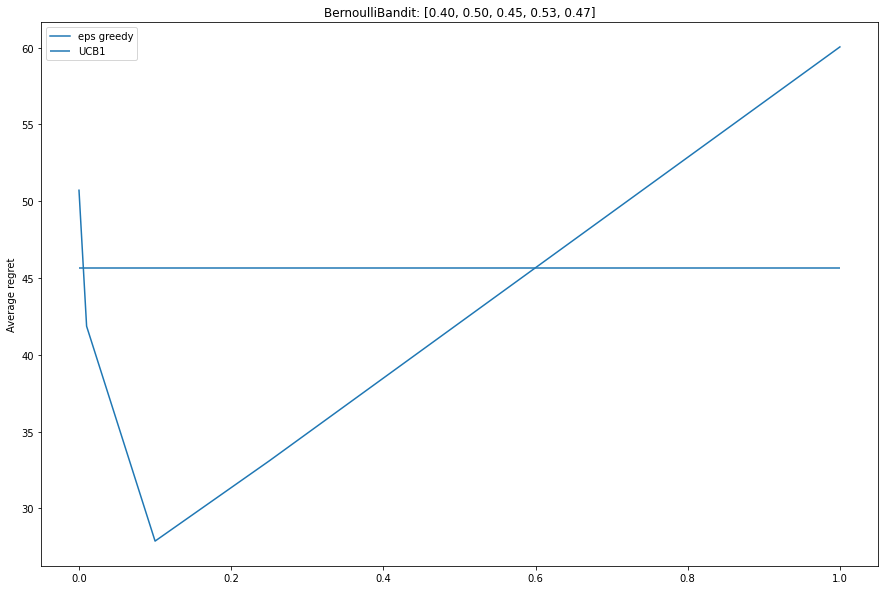

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(eps_greedy_values, bandit_2_average_regrets_short[:-1])
plt.hlines(bandit_2_average_regrets_short[-1], 0, 1)
plt.legend(['eps greedy', 'UCB1'])
plt.title(str(bandit_2))
plt.ylabel("Average regret")
plt.show()

## Опциональное задание

1. Реализовать стратегию сэмплирования Томпсона. В качестве априорного распределения использовать равномерное (beta-распределение с параметрами $\alpha=1, \beta=1$)
2. Сравнить следующие стратегии:
  - сэмплирование Томпсона
  - epsilon greedy при epsilon=0.1
  - epsilon greedy при epsilon=0.25
  - epsilon greedy при epsilon=0.05
  - UCB1

  для следующего кол-ва шагов: `steps = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]`

  и следующих многоруких бандитов:

  ```
    import hashlib
    def get_my_random_seed(family_name):
        return int(hashlib.sha1(family_name.encode("utf-8")).hexdigest(), 16) % (2 ** 32)

    np.random.seed(get_my_random_seed("<Фамилия> <Имя>"))
    bandits_to_test = [
        BernoulliBandit(4, probas=[0.52, 0.48, 0.37, 0.5]),
        BernoulliBandit(4, probas=[0.5, 0.6, 0.4, 0.75]),
        BernoulliBandit(4, probas=np.concatenate(
            [np.random.beta(100, 120, size=2), np.random.beta(120, 100, size=2)]))
]
  ```
  где в `get_my_random_seed` необходимо передать строку с вашими фамилией и именем


Дополнительная литература:

https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

